Kaggle Grandmasters approve the best way to do EDA in a computer vision competition is to look at all images one by one.

This competition is an instance segmentation not a semantic segmentation, meaning that we need to detect each instance (a single nuclei) one by one. But we will still explore semantic segmentation methods such as Unet.

### Display an Image

In [567]:
from utility.utils import * 

In [568]:
MAIN_PATH = '../data/ds_bowl_2018/full_data/'

In [569]:
# collect for image 0
image_path, mask_paths, image_id = get_img_mask_paths(MAIN_PATH, 0)

In [570]:
print(f'id {image_id} has {len(mask_paths)} masks')

id ../data/ds_bowl_2018/full_data/58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd has 18 masks


In [571]:
combined_mask = create_one_mask_arr(mask_paths)

In [572]:
# creating one mask file
create_one_mask_file(mask_paths, image_id)

58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd.png


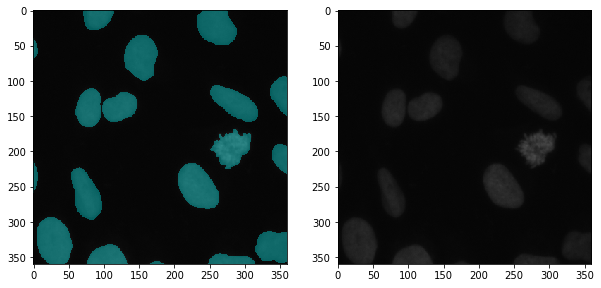

In [574]:
show_image(image_path, image_id + '/one_mask.png', figsize=(10, 10))

### Create one mask for every image

In [ ]:
n_images = len([p for p in os.listdir(MAIN_PATH) if '.csv' not in p])

In [ ]:
for i in range(n_images):
    try:
        image_path, mask_paths, image_id = get_img_mask_paths(MAIN_PATH, i)
        # creating one mask file
        create_one_mask_file(mask_paths, image_id)
    except: pass

### Display Training Image-Mask pair

**Image Characteristics**

- Black background white foreground (majority class)
- Pink background purple foreground
- White background with ghost cells with very small nuclei
- White background purple foreground
- Zoomed images in purple-white background with darker purple foreground
- Very small nucleus cluttered around an ellipsoid.
- Images with overlaps or a lot of small nuclei all over will give Unet hard time, without instance detection.

In [ ]:
for i in range(650):
    try:
        # collect for image 0
        image_path, mask_paths, image_id = get_img_mask_paths(MAIN_PATH, i)
        show_image(image_path, image_id + '/one_mask.png', figsize=(10, 10))
    except: pass

### Display Test Images

It's a good strategy to look at test images to come up with a good validation set.

**Image Characteristics**

- Black background white foreground (majority class)
- Blue(Cyan) background purple foreground
- Zoomed images with white background purple foreground

As you will notice we don't have such images as blue(cyan) background with white foreground in training data, which may make it hard to generalize to such images.

In [575]:
test_path = '../data/ds_bowl_2018/test/'

In [576]:
test_image_paths = get_image_onemask_paths(test_path, False)

In [ ]:
print(len(test_image_paths))
for path in test_image_paths:
    show_image(path, figsize=(5, 5))

### Display Image Sizes

In [ ]:
img_szs = []
for i in range(n_images):
    image_path, _, image_id = get_img_mask_paths(MAIN_PATH, i)
    H,W,C = cv2.imread(image_path, cv2.IMREAD_COLOR).shape
    img_szs.append((H, W))

In [ ]:
from collections import defaultdict

img_szs_dict = defaultdict(int)
for h, w in img_szs:
        img_szs_dict[(h, w)] += 1

In [ ]:
img_szs_dict

### Data Augmentation

Data Augmentation is important to get more images when we have a small dataset. Below is a subset of what can be done.

In [8]:
from dataset.dataset import *
from dataset.transform import *

#### Original

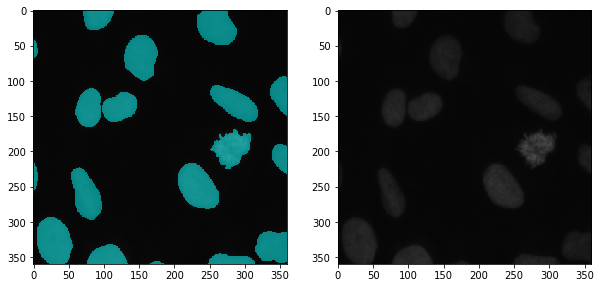

In [11]:
full_ds = NucleiDataset(MAIN_PATH, transform=None)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

#### Resize - 256x256

In [12]:
def augment(image, mask, index):
    image, mask = fix_resize_transform2(image, mask, 256, 256)
    return image, mask, index

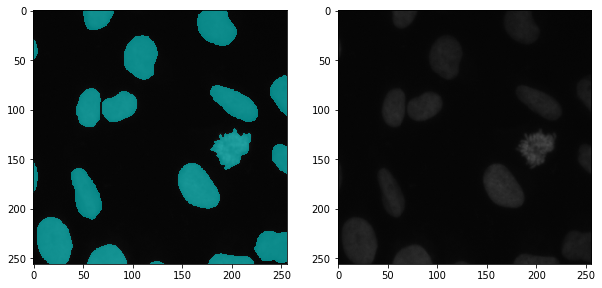

In [13]:
full_ds = NucleiDataset(MAIN_PATH, transform=augment)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

#### Resize + Horizontal Flip

In [14]:
def augment(image, mask, index):
    image, mask = fix_resize_transform2(image, mask, 256, 256)
    image, mask = random_horizontal_flip_transform2(image, mask, p=1)
    return image, mask, index

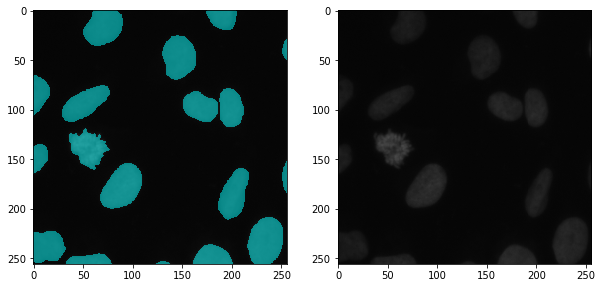

In [15]:
full_ds = NucleiDataset(MAIN_PATH, transform=augment)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

#### Resize + Vertical Flip

In [18]:
def augment(image, mask, index):
    image, mask = fix_resize_transform2(image, mask, 256, 256)
    image, mask = random_vertical_flip_transform2(image, mask, p=1)
    return image, mask, index

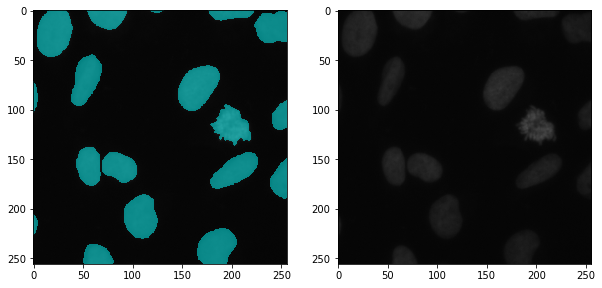

In [19]:
full_ds = NucleiDataset(MAIN_PATH, transform=augment)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

#### Resize + Random Rotate 0, 90, 180, 270

In [20]:
def augment(image, mask, index):
    image, mask = fix_resize_transform2(image, mask, 256, 256)
    image, mask = random_rotate_transform2(image, mask, p=1)
    return image, mask, index

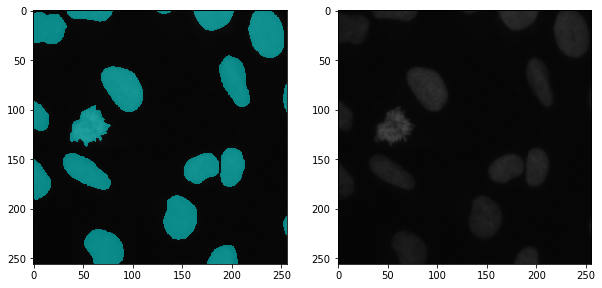

In [22]:
full_ds = NucleiDataset(MAIN_PATH, transform=augment)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

#### Resize + Random Angle Rotate (picks $\alpha$ randomly from range(0, 360, 10))

In [38]:
def augment(image, mask, index):
    image, mask = fix_resize_transform2(image, mask, 256, 256)
    image, mask = random_rotate_angle_transform2(image, mask, p=1)
    return image, mask, index

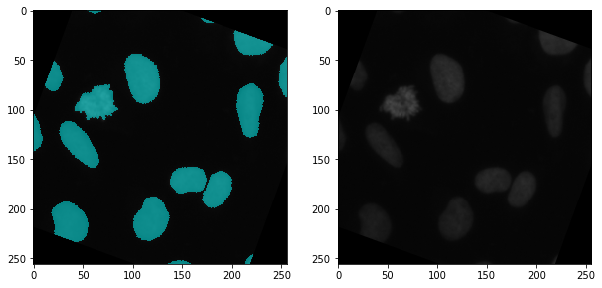

In [39]:
full_ds = NucleiDataset(MAIN_PATH, transform=augment)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

#### Crop and Resize + Resize

In [519]:
def augment(image, mask, index):
    # first crop not to lose resolution then resize
    image, mask = random_crop_resize2(image, mask, p=1)
    image, mask = fix_resize_transform2(image, mask, 256, 256)
    return image, mask, index

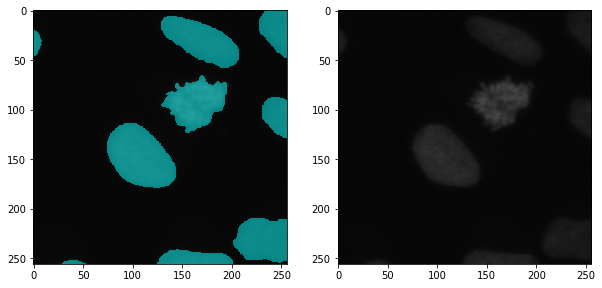

In [521]:
full_ds = NucleiDataset(MAIN_PATH, transform=augment)
img, mask, _ = full_ds.__getitem__(0)
show_image2(img, mask, 0.5, figsize=(10, 10))

### Grayscale

In [577]:
test_image_paths

['../data/ds_bowl_2018/test/31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a/images/31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a.png',
 '../data/ds_bowl_2018/test/c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb/images/c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb.png',
 '../data/ds_bowl_2018/test/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8/images/ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8.png',
 '../data/ds_bowl_2018/test/df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8/images/df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8.png',
 '../data/ds_bowl_2018/test/a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f/images/a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f.png',
 '../data/ds_bowl_2018/test/505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81/images/505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15c

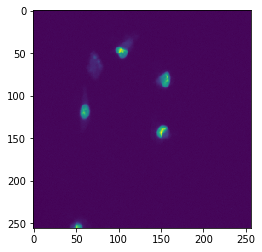

In [579]:
plt.imshow(read2d(test_image_paths[0]))

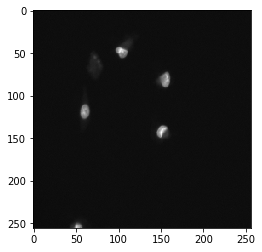

In [580]:
plt.imshow(read3d(test_image_paths[0]))